In [1]:
import geopandas as gp 
import numpy as np 
import json
import pandas as pd 
import sys 
sys.path.insert(0, '/home/nicolas/hpchome/network_conditioning/codes/')
import network_functions as netf
import pylab as pl 

# Example with an small network 

In [2]:
net = gp.read_file('../maps/demnet_no_ghosts.shp')
net.set_index('LINKNO', inplace = True)

In [6]:
link = 6811
sub = netf.get_subwatershed(net, link)

In [21]:
def hlm_write_rvr(net, path):
    '''Takes a network that has been proccessed with remove_virtual_links.py and extracts the rvr 
    file required for HLM at the designed path'''
    parents_name = ['us%d' % i for i in range(1,11)]
    with open(path,'w',newline='\n') as f:
        f.write('%d\n' % net.shape[0])
        f.write('\n')
        for link in net.index:
            f.write('%d\n' % link)
            if net.loc[link,'us1'] == -1:
                f.write('0\n')
            else:
                parents = net.loc[link, parents_name].values
                parents = parents[parents > 0]
                f.write('%d ' % parents.size)
                for parent in parents:
                    f.write('%d ' % parent)
                f.write('\n\n')            
            f.write('\n')
        f.close()

In [22]:
path = '../hlm_files/example.rvr'
hlm_write_rvr(sub, '../hlm_files/example2.rvr')

# Fix the hillslope area of the network (already done, just load the network)

In [9]:
#Read the network
net = pd.read_parquet('../local_data/tables/links_ifis.gz')
net.set_index('LINKNO', inplace = True)

In [10]:
#USGS gauges linked to network 
usgs = pd.read_csv('../local_data/tables/usgs_temporal_linked_w_trimmed.csv')
usgs.set_index('LINKNO', inplace = True)
usgs.drop_duplicates(inplace = True)
usgs['net_area'] = net.loc[usgs.index,'DSContArea']/1e6

The following cod takes a table with the hillslopes area information and adds it to the links 

In [ ]:
#Read the hillslope areas 
# hills = pd.read_csv('../local_data/tables/hills_from_trimmed.csv')
# hills.set_index('LINKNO', inplace = True)
# hills = hills.groupby(hills.index).sum()
# idx = net.index.intersection(hills.index)
# net.loc[idx, 'area'] = hills.loc[idx, 'area']
# net.reset_index(inplace=True)
# net.to_parquet('../local_data/tables/links_ifis.gz')

# Case with the final network 

In [2]:
# net = pd.read_csv('../local_data/links_all_no_ghosts.csv')
# sel = pd.read_csv('../local_data/links_final_sel.csv')
# net.set_index('LINKNO', inplace = True)
# net = net.loc[sel['LINKNO'].values]

In [10]:
# net.drop(['us%d' % i for i in range(5,11)],axis = 1, inplace = True)

In [12]:
# net.reset_index(inplace=True)

In [16]:
# net[['LINKNO','np','us1','us2','us3','us4']].to_csv('../local_data/links_final_sel_w_new_parents.csv')

### Another case with the trimmed network here we save it as a parquet 

In [56]:
net = pd.read_csv('../local_data/tables/links_final_sel_w_new_parents_trimmed.csv')
net[['LINKNO','strmOrder','DSContArea','USContArea','strmDrop','Slope','StraightL','Length','np','us1','us2','us3','us4']].to_parquet('../local_data/tables/links_ifis.gz',                                                                                                                                      compression = 'gzip')

# Set files to run Turkey

In [18]:
net_turkey = netf.get_subwatershed(net, 1840958)

In [58]:
net_turkey.loc[net_turkey['area'] < 200].shape

(12, 13)

In [6]:
netf.hlm_write_rvr(net_turkey, '../local_data/ifis_config/turkey.rvr')

In [19]:
model = '608'
netf.hlm_write_prm(net_turkey, '../local_data/ifis_config/turkey.prm')

In [14]:
f = open('../local_data/ifis_config/turkey.sav','w')
for i in usgs.index.intersection(net_turkey.index):
    f.write('%d\n' % i)
f.close()


# Files to run Cedar River

In [20]:
net_cedar = netf.get_subwatershed(net, 1844585)

In [21]:
netf.hlm_write_rvr(net_cedar, '../local_data/ifis_config/cedar.rvr')

In [23]:
model = '608'
netf.hlm_write_prm(net_cedar, '../local_data/ifis_config/cedar.prm')

In [19]:
f = open('../local_data/ifis_config/cedar.sav','w')
for i in usgs.index.intersection(net_cedar.index):
    f.write('%d\n' % i)
f.close()


# Files for Iowa river at Columbus Junction

In [12]:
net_iowa = netf.get_subwatershed(net, 1589912)

In [13]:
netf.hlm_write_rvr(net_iowa, '../local_data/ifis_config/iowa_river.rvr')

In [14]:
netf.hlm_write_prm(net_iowa, '../local_data/ifis_config/iowa_river.prm', model=None)

In [18]:
net_iowa.reset_index(inplace=True)
net_iowa.to_csv('../local_data/ifis_config/temp_iowa_river.csv')

## Files for Waverly (Cedar River)

In [12]:
net_wav = netf.get_subwatershed(net, 1862015)
netf.hlm_write_rvr(net_wav, '../local_data/ifis_config/waverly.rvr')
netf.hlm_write_prm(net_wav, '../local_data/ifis_config/waverly.prm', model=None)

In [13]:
net_wav.reset_index(inplace=True)
net_wav.to_csv('../local_data/ifis_config/waverly.csv')

# Set files for running the state

## Test network coherence 

In [12]:
noparents = []
for link in net.index:
    nparents = net.loc[link, 'np']
    for parent in np.arange(1, nparents+1):
        pname = 'us%d' % parent
        plink = net.loc[link, pname]
        try:
            net.loc[plink]
        except:
            noparents.append(link)
            print(link)

## RVR for the state 

In [11]:
netf.hlm_write_rvr(net, '../local_data/ifis_config/ifis_iowa.rvr')

## PRM for the state 

In [19]:
mprm = netf.hlm_load_prm_configs('../codes/model_prm_config.json')

In [20]:
mprm

{'608': ['0.0200 1.6700 3.20e-06 17.0 5.40e-07 32.0 2.04e-06 0.020 0.100 1.480 1.635 1.670 0.250 -0.10 0.320']}

In [11]:
path = '../hlm_files/ifis_iowa.prm'
model = '608'
netf.hlm_write_prm(net, path, modprm=mprm)

# USGS and IFC gauges link and area testing

## USGS

In [3]:
#Read network table
net = pd.read_parquet('../local_data/tables/links_ifis.gz')
net.set_index('LINKNO', inplace = True)
#net['area'] = (net['DSContArea'] - net['USContArea'])/1e6

In [68]:
#Read hills table 
hills = pd.read_csv('../local_data/tables/hills_from_trimmed.csv')
hills = hills.groupby('LINKNO')['area'].sum().reset_index()
hills.set_index('LINKNO', inplace = True)

### Identify gauges with issues 

In [17]:
usgs['area_error'] = (usgs['DRAIN_SQKM'] - usgs['net_area'])/usgs['DRAIN_SQKM']

In [18]:
usgs.loc[(usgs['area_error']<-0.1) | (usgs['area_error']>0.1)]

,STAID,STANAME,DRAIN_SQKM,net_area,area_error
LINKNO,,,,,
901009,6481000,BIG SIOUX R NEAR DELL RAPIDS SD,9662.446,11233.865728,-0.162632
1384635,6482020,BIG SIOUX R AT NORTH CLIFF AVE AT SIOUX FALLS SD,11568.330,13141.665792,-0.136004


### Create Sav file for the model using the usgs gauges 

In [19]:
f = open('../hlm_files/ifis_usgs.sav','w')
for i in usgs.index:
    f.write('%d\n' % i)
f.close()

### Compute upstream from hills

In [78]:
from multiprocessing import Pool 
#Define a warper function and the list with the parameters to obtain the list of links for each watershed
def warp(params):
    return netf.get_subwatershed(*params).index
params = [(net, i) for i in usgs.index]

In [91]:
#Obtain the list of links for all the gauges 
p = Pool(30)
links_lids = p.map(warp, params)
p.close()
p.join()

In [99]:
#Oranize the data to save it
links_lids_dict = {}
for lid, _list in zip(usgs.index, links_lids):
    links_lids_dict.update({str(lid):_list.tolist()})
#Save results to a json
with open('../local_data/usgs_links_upstream.json','w') as f:
    json.dump(links_lids_dict, f)

In [100]:
#Load the data
with open('../local_data/usgs_links_upstream.json','r') as f:
    links_lids_dict = json.load(f)

#### Compute the area form the hillslopes 

In [104]:
#Compute the area form the hillslopes 
areas_from_hills = []
for lid in links_lids_dict.keys():
    areas_from_hills.append(hills.loc[links_lids_dict[lid],'area'].sum())
_d = pd.DataFrame(areas_from_hills, index=[int(lid) for lid in links_lids_dict.keys()], columns=['area_hill'])

In [112]:
usgs['hill_area'] = _d.loc[usgs.index,'area_hill']

Text(0, 0.5, 'USGS reported area [$km^2$]')

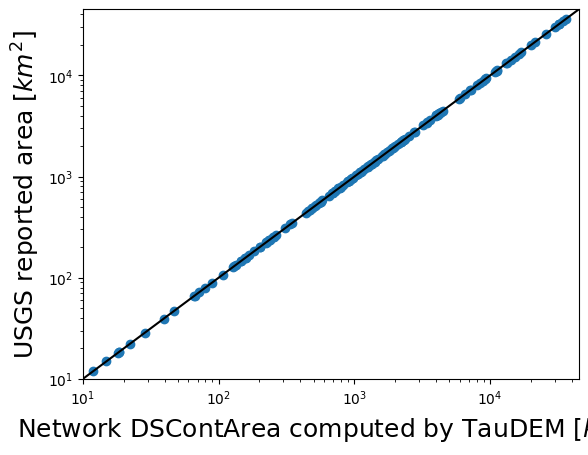

In [116]:
pl.scatter(usgs['net_area'], usgs['hill_area'])
pl.plot([10,45000],[10,45000],'k')
pl.xlim(10,45000)
pl.ylim(10,45000)
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Network DSContArea computed by TauDEM [$km^2$]', size  =18)
pl.ylabel('USGS reported area [$km^2$]', size  =18)

Text(0, 0.5, 'USGS reported area [$km^2$]')

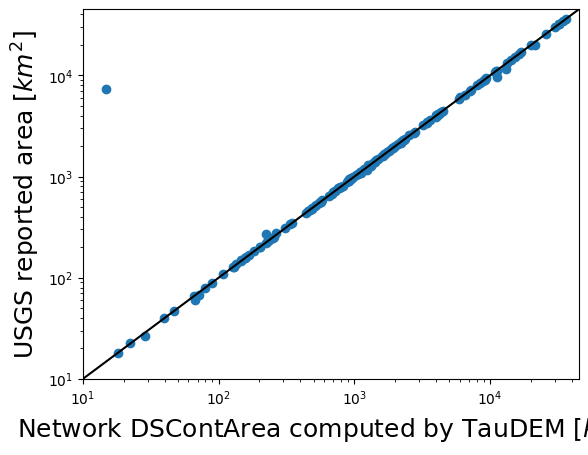

In [11]:
pl.scatter(usgs['net_area'], usgs['DRAIN_SQKM'])
pl.plot([10,45000],[10,45000],'k')
pl.xlim(10,45000)
pl.ylim(10,45000)
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Network DSContArea computed by TauDEM [$km^2$]', size  =18)
pl.ylabel('USGS reported area [$km^2$]', size  =18)

In [4]:
net['area_km'] = net['area']/1e6
#net.loc[net['area_km'] < min_area, 'area_km'] = 0.01
net['area_up_km'] = net['DSContArea'] / 1e6
net['length_km'] = net['Length']/1000
#net.loc[net['length_km'] < min_area, 'length_km'] = 0.01

## IFC

In [64]:
#Reads the network 
net = pd.read_parquet('../local_data/tables/links_ifis_w_downstream.gz')
net.set_index('LINKNO', inplace = True)
net['area_up_km'] = net['DSContArea'] / 1e6
#Reads the IFC data
ifc = pd.read_csv('../local_data/tables/ifc_linked_w_trimmed.csv')
ifc.set_index('LINKNO', inplace = True, )
ifc['area_up_km'] = ifc['upstream_a'] * 2.58
#Compute the error at the links with area (non-area reported I checked them by hand)
idx = ifc.index.intersection(net.index)
ifc['a_error'] =(ifc.loc[idx, 'area_up_km'] - net.loc[idx, 'area_up_km'])/ifc.loc[idx, 'area_up_km']
#Check the ones with largest area error
_ifc = ifc.dropna()
_ifc = _ifc.loc[np.isfinite(ifc['a_error'])]
_ifc.sort_values('a_error', ascending=False).head(10)

,#id,foreign_id,total_area,upstream_a,town,river,n,distance,feature_x,feature_y,nearest_x,nearest_y,area_up_km,a_error
LINKNO,,,,,,,,,,,,,,
1420114,1839,GENEVACR01,0.0,3.0,Muscatine,Geneva Creek,1,2.618152,662434.277915,4.590444e+06,662434.277915,4.590446e+06,7.74,0.247786
1810522,1663,ONIONCR01,0.0,18.0,Ames,Onion Creek,1,9.164474,442193.298010,4.655956e+06,442193.298010,4.655946e+06,46.44,0.155294
1608487,999,BFFLOCR02,0.0,5.0,Tiffin,Buffalo Creek,1,0.644552,610907.457440,4.619903e+06,610907.913208,4.619903e+06,12.90,0.109685
1562510,716,CHSLSCR01,0.0,12.0,Mason City,Cheslea Creek,1,5.093006,481616.291347,4.775701e+06,481611.198341,4.775701e+06,30.96,0.084617
1866513,732,LAKECR01,0.0,132.0,Lake City,Lake Creek,1,5.779862,352986.692115,4.680244e+06,352980.912252,4.680244e+06,340.56,0.080078
1668520,1034,CLRCRKS02,0.0,4.0,Williamsburg,Clear Creek Tributary,1,0.109322,590605.383395,4.615542e+06,590605.460697,4.615542e+06,10.32,0.072475
1626855,1000,BFFLOCR01,0.0,8.0,Tiffin,Buffalo Creek,1,2.031594,608189.180188,4.618651e+06,608187.743633,4.618653e+06,20.64,0.071545
1647014,1817,RAPIDTRB01,0.0,7.0,Morse,Rapid Creek Tributary,1,15.059111,630218.565405,4.623021e+06,630207.916997,4.623010e+06,18.06,0.061860
1714606,754,WLLWCR01,0.0,103.0,Mason City,Willow Creek,1,1.127142,483174.788015,4.777585e+06,483173.991005,4.777584e+06,265.74,0.057233
